# 野球チームの『攻撃力』と『守備力』を計算して、4つのタイプに分類・可視化する分析ツール

現在の作業フォルダ: /Users/yurienamekawa/Desktop/MU/DSprogramming_2/dsprog2/lecture-sp
このフォルダ内のCSVファイルを探します...
データ読み込み開始...
データ読み込み完了！
=== 各チームタイプ統計分析 ===
総チーム数: 12

【攻守兼備型】チーム数: 2
平均勝率: 0.549
含まれるチーム: オリックス, ソフトバンク
--------------------------------------------------
【強攻弱守型】チーム数: 3
平均勝率: 0.500
含まれるチーム: 巨人, ヤクルト, DeNA
--------------------------------------------------
【弱攻強守型】チーム数: 4
平均勝率: 0.484
含まれるチーム: 中日, 阪神, 西武, 日本ハム
--------------------------------------------------
【低迷型】チーム数: 3
平均勝率: 0.487
含まれるチーム: 広島, ロッテ, 楽天
--------------------------------------------------


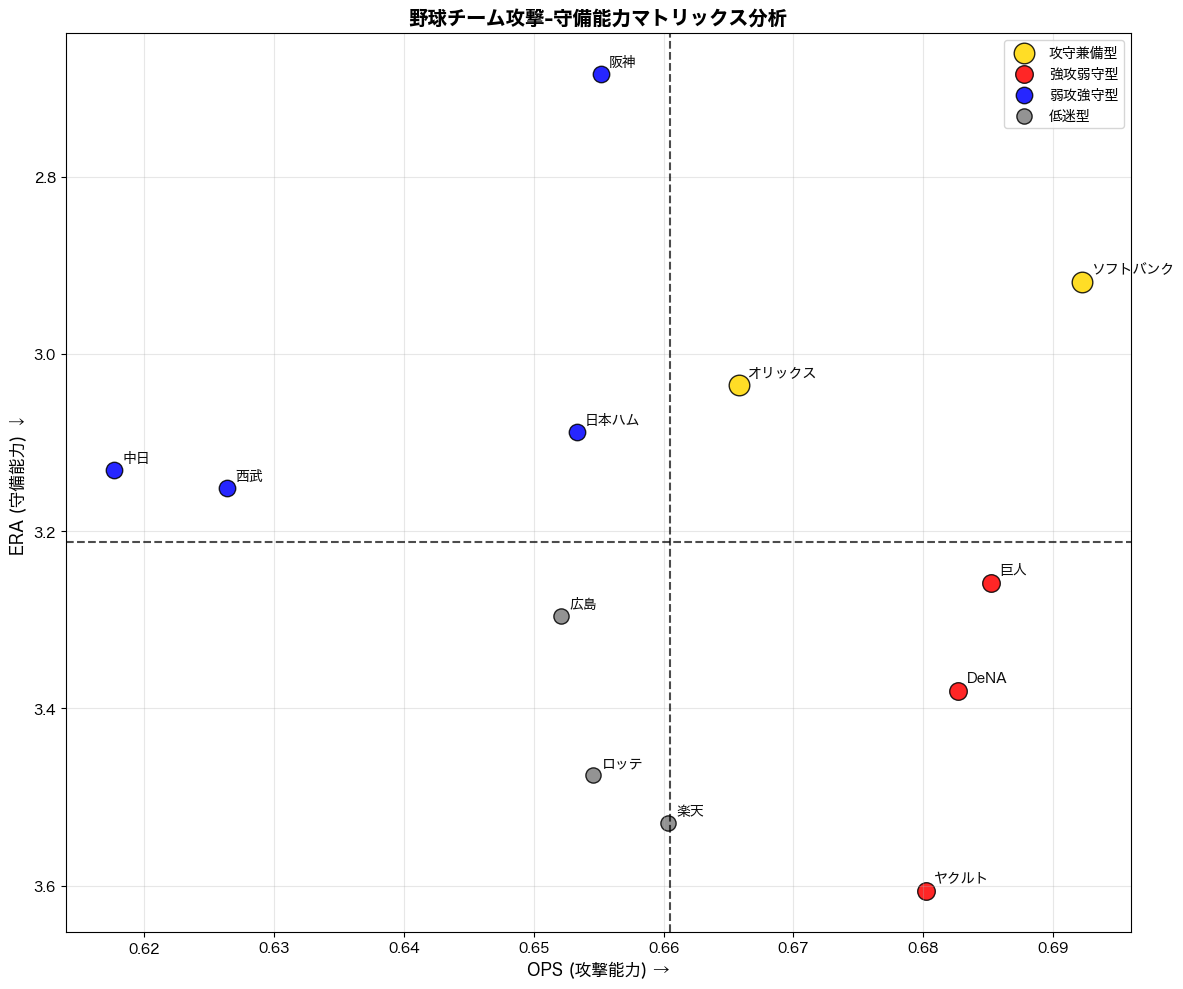


=== 最適閾値の検索 ===
最適OPS: 0.667, 最適ERA: 3.10

分析結果を保存しました: /Users/yurienamekawa/Desktop/MU/DSprogramming_2/dsprog2/lecture-sp/team_analysis_results.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

# 日本語フォント設定
# Mac用のフォント「ヒラギノ角ゴシック」を指定します
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False    # マイナス記号を正常に表示するため

def read_csv_with_fallback(path, encodings=None, **kwargs):
    """
    複数のエンコーディングでCSVを読み込む
    """
    if encodings is None:
        encodings = ['shift_jis', 'cp932', 'utf-8', 'utf-8-sig', 'gbk', 'cp1252', 'latin1']

    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except UnicodeDecodeError as e:
            last_err = e
            continue
        except FileNotFoundError:
            raise
        except Exception as e:
            raise

    raise last_err

class BaseballTeamAnalyzer:
    def __init__(self, stats_bat_path, stats_pit_path, games_path):
        """
        アナライザーの初期化
        """
        print(f"データ読み込み開始...")
        # 読み込み実行
        self.stats_bat = read_csv_with_fallback(stats_bat_path)
        self.stats_pit = read_csv_with_fallback(stats_pit_path)
        self.games = read_csv_with_fallback(games_path)
        print("データ読み込み完了！")
        
    def calculate_team_win_rate(self):
        """各チームの勝率を計算"""
        win_records = []
        
        for _, game in self.games.iterrows():
            home_team = game['home_team_id']
            away_team = game['away_team_id']
            home_score = game['home_team_score']
            away_score = game['away_team_score']
            
            if home_score > away_score:
                win_records.append({'team_id': home_team, 'win': 1, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 0, 'game': 1})
            elif away_score > home_score:
                win_records.append({'team_id': home_team, 'win': 0, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 1, 'game': 1})
            else:
                win_records.append({'team_id': home_team, 'win': 0.5, 'game': 1})
                win_records.append({'team_id': away_team, 'win': 0.5, 'game': 1})
        
        win_df = pd.DataFrame(win_records)
        team_win_rate = win_df.groupby('team_id').agg({
            'win': 'sum',
            'game': 'sum'
        }).reset_index()
        
        team_win_rate['win_rate'] = team_win_rate['win'] / team_win_rate['game']
        return team_win_rate

    def calculate_team_ops(self):
        """各チームのOPS（出塁率+長打率）を計算"""
        team_batting = self.stats_bat.groupby('team_id').agg({
            'h': 'sum', 'h1b': 'sum', 'h2b': 'sum', 'h3b': 'sum',
            'hr': 'sum', 'bb': 'sum', 'hbp': 'sum', 'ab': 'sum',
            'pa': 'sum', 'team_name': 'first'
        }).reset_index()
        
        team_batting['avg'] = team_batting['h'] / team_batting['ab']
        team_batting['obp'] = (team_batting['h'] + team_batting['bb'] + team_batting['hbp']) / team_batting['pa']
        team_batting['slg'] = (team_batting['h1b'] + 2*team_batting['h2b'] + 3*team_batting['h3b'] + 4*team_batting['hr']) / team_batting['ab']
        team_batting['ops'] = team_batting['obp'] + team_batting['slg']
        
        return team_batting[['team_id', 'team_name', 'avg', 'obp', 'slg', 'ops']]

    def calculate_team_era(self):
        """各チームの防御率(ERA)を計算"""
        team_pitching = self.stats_pit.groupby('team_id').agg({
            'er': 'sum', 'ip': 'sum', 'team_name': 'first'
        }).reset_index()
        
        team_pitching['era'] = (team_pitching['er'] * 9) / team_pitching['ip']
        return team_pitching[['team_id', 'team_name', 'era']]

    def build_offense_defense_model(self, ops_threshold=None, era_threshold=None):
        """攻撃-守備モデルの構築"""
        win_rates = self.calculate_team_win_rate()
        ops_data = self.calculate_team_ops()
        era_data = self.calculate_team_era()
        
        team_data = pd.merge(win_rates, ops_data, on='team_id')
        team_data = pd.merge(team_data, era_data, on='team_id')

        # team_nameの重複処理
        if 'team_name' not in team_data.columns:
            if 'team_name_x' in team_data.columns:
                team_data['team_name'] = team_data['team_name_x']
            elif 'team_name_y' in team_data.columns:
                team_data['team_name'] = team_data['team_name_y']

        for col in ['team_name_x', 'team_name_y']:
            if col in team_data.columns:
                team_data.drop(columns=[col], inplace=True)
        
        if ops_threshold is None:
            ops_threshold = team_data['ops'].mean()
        if era_threshold is None:
            era_threshold = team_data['era'].mean()
        
        def classify_team(row):
            if row['ops'] >= ops_threshold and row['era'] <= era_threshold:
                return '攻守兼備型'
            elif row['ops'] >= ops_threshold and row['era'] > era_threshold:
                return '強攻弱守型'
            elif row['ops'] < ops_threshold and row['era'] <= era_threshold:
                return '弱攻強守型'
            else:
                return '低迷型'
        
        team_data['team_type'] = team_data.apply(classify_team, axis=1)
        return team_data, ops_threshold, era_threshold

    def plot_offense_defense_matrix(self, team_data, ops_threshold, era_threshold):
        """攻撃-守備四象限図の描画"""
        plt.figure(figsize=(12, 10))
        
        colors = {'攻守兼備型': 'gold', '強攻弱守型': 'red', '弱攻強守型': 'blue', '低迷型': 'gray'}
        sizes = {'攻守兼備型': 220, '強攻弱守型': 160, '弱攻強守型': 140, '低迷型': 120}
        
        for team_type, color in colors.items():
            mask = team_data['team_type'] == team_type
            if not mask.any(): continue
            
            plt.scatter(team_data.loc[mask, 'ops'], 
                       team_data.loc[mask, 'era'],
                       c=color, label=team_type, s=sizes.get(team_type, 100), 
                       alpha=0.85, edgecolors='k')

            for _, row in team_data[mask].iterrows():
                plt.annotate(row['team_name'], (row['ops'], row['era']),
                             xytext=(6, 6), textcoords='offset points',
                             fontsize=10, alpha=0.95)
        
        plt.axvline(x=ops_threshold, color='black', linestyle='--', alpha=0.7)
        plt.axhline(y=era_threshold, color='black', linestyle='--', alpha=0.7)
        plt.xlabel('OPS (攻撃能力) →', fontsize=12)
        plt.ylabel('ERA (守備能力) ↓', fontsize=12)
        plt.title('野球チーム攻撃-守備能力マトリックス分析', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def analyze_team_types(self, team_data):
        print("=== 各チームタイプ統計分析 ===")
        print(f"総チーム数: {len(team_data)}\n")
        for team_type in ['攻守兼備型', '強攻弱守型', '弱攻強守型', '低迷型']:
            type_data = team_data[team_data['team_type'] == team_type]
            if len(type_data) > 0:
                print(f"【{team_type}】チーム数: {len(type_data)}")
                print(f"平均勝率: {type_data['win_rate'].mean():.3f}")
                print(f"含まれるチーム: {', '.join(type_data['team_name'].tolist())}")
                print("-" * 50)

    def find_optimal_thresholds(self, team_data):
        best_score = 0
        best_ops = team_data['ops'].mean()
        best_era = team_data['era'].mean()
        
        ops_range = np.linspace(team_data['ops'].quantile(0.3), team_data['ops'].quantile(0.7), 20)
        era_range = np.linspace(team_data['era'].quantile(0.3), team_data['era'].quantile(0.7), 20)
        
        for ops_thresh in ops_range:
            for era_thresh in era_range:
                champion_teams = team_data[
                    (team_data['ops'] >= ops_thresh) & (team_data['era'] <= era_thresh)
                ]
                if len(champion_teams) > 0:
                    score = champion_teams['win_rate'].mean()
                    if score > best_score:
                        best_score = score
                        best_ops = ops_thresh
                        best_era = era_thresh
        return best_ops, best_era, best_score

# ==========================================
# メイン実行ブロック（ここが変わりました）
# ==========================================
if __name__ == "__main__":
    # 【変更点】
    # os.getcwd() を使って「今コードを実行しているフォルダ」を自動で取得します。
    # これにより、どのPCで実行しても（フォルダごと移動させても）動くようになります。
    data_dir = os.getcwd()

    print(f"現在の作業フォルダ: {data_dir}")
    print("このフォルダ内のCSVファイルを探します...")

    # 相対パスでのファイル指定（data_dir とファイル名を結合）
    stats_bat_path = os.path.join(data_dir, 'stats_bat.csv')
    stats_pit_path = os.path.join(data_dir, 'stats_pit.csv')
    games_path = os.path.join(data_dir, 'games.csv')

    try:
        analyzer = BaseballTeamAnalyzer(stats_bat_path, stats_pit_path, games_path)
        
        # モデル構築・分析
        team_data, ops_threshold, era_threshold = analyzer.build_offense_defense_model()
        analyzer.analyze_team_types(team_data)
        analyzer.plot_offense_defense_matrix(team_data, ops_threshold, era_threshold)
        
        # 最適化と結果保存
        print("\n=== 最適閾値の検索 ===")
        best_ops, best_era, best_score = analyzer.find_optimal_thresholds(team_data)
        print(f"最適OPS: {best_ops:.3f}, 最適ERA: {best_era:.2f}")
        
        team_data_optimized, _, _ = analyzer.build_offense_defense_model(
            ops_threshold=best_ops, era_threshold=best_era
        )
        
        save_path = os.path.join(data_dir, 'team_analysis_results.csv')
        team_data_optimized.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"\n分析結果を保存しました: {save_path}")
        
    except FileNotFoundError as e:
        print("\n!!! エラー: ファイルが見つかりません !!!")
        print(f"現在探している場所: {data_dir}")
        print("CSVファイル（stats_bat.csvなど）が、このipynbファイルと同じフォルダにあるか確認してください。")